### Importación de bibliotecas

In [5]:
import sys
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Establecer conexión a la base de datos PostgreSQL

In [6]:
sys.path.append(os.path.abspath('../source'))

from BD_connection import get_connection

conexion = get_connection()


2025-04-11 16:04:35,547 - INFO - Conexión a la base de datos 'grammys_db' creada exitosamente.


### Leer datos de la tabla 'raw_grammy' desde la base de datos

In [7]:
df = pd.read_sql_query("SELECT * FROM raw_grammy", conexion)
print(df.head())

   year                              title               published_at  \
0  2019  62nd Annual GRAMMY Awards  (2019)  2020-05-19T05:10:28-07:00   
1  2019  62nd Annual GRAMMY Awards  (2019)  2020-05-19T05:10:28-07:00   
2  2019  62nd Annual GRAMMY Awards  (2019)  2020-05-19T05:10:28-07:00   
3  2019  62nd Annual GRAMMY Awards  (2019)  2020-05-19T05:10:28-07:00   
4  2019  62nd Annual GRAMMY Awards  (2019)  2020-05-19T05:10:28-07:00   

                  updated_at            category     nominee         artist  \
0  2020-05-19T05:10:28-07:00  Record Of The Year     Bad Guy  Billie Eilish   
1  2020-05-19T05:10:28-07:00  Record Of The Year     Hey, Ma       Bon Iver   
2  2020-05-19T05:10:28-07:00  Record Of The Year     7 rings  Ariana Grande   
3  2020-05-19T05:10:28-07:00  Record Of The Year  Hard Place         H.E.R.   
4  2020-05-19T05:10:28-07:00  Record Of The Year        Talk         Khalid   

                                             workers  \
0  Finneas O'Connell, producer

### Mostrar información general del DataFrame

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


El dataset tiene una cantidad significativa de valores nulos, especialmente en artist (38% nulos) y workers (45% nulos), lo que indica que la imputación de artistas será crucial para análisis posteriores.
La columna nominee tiene pocos nulos (6 filas), pero estos casos pueden requerir atención especial, ya que nominee es un campo clave.
La ausencia de nulos en year, category, y winner sugiere que estos campos son confiables para análisis de tendencias o agrupaciones.

### Identificar y mostrar filas duplicadas (si las hay)

In [9]:
duplicate_values= df[df.duplicated(keep=False)]
print("Datos duplicados:\n", duplicate_values)

Datos duplicados:
 Empty DataFrame
Columns: [year, title, published_at, updated_at, category, nominee, artist, workers, img, winner]
Index: []


La ausencia de duplicados exactos indica que el dataset está limpio en términos de entradas redundantes idénticas.

## Manejo de Nulos

In [10]:
null_values= df.isnull().sum()
print("Valores nulos:\n", null_values)

Valores nulos:
 year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist          1840
workers         2190
img             1367
winner             0
dtype: int64


La alta proporción de nulos en artist y workers destaca la necesidad de estrategias de imputación, como usar nominee o workers para llenar artist cuando sea posible.
Los 6 nulos en nominee representan un problema menor, pero podrían corresponder a categorías específicas que no especifican nominados.
La columna img tiene nulos significativos, pero puede ser menos crítica si el análisis se centra en datos textuales.

#### Mostrar filas donde la columna 'nominee' es nula

In [11]:
df.loc[df["nominee"].isna()]

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
2274,2000,43rd Annual GRAMMY Awards (2000),2017-11-28T00:03:45-08:00,2019-09-10T01:11:09-07:00,"Remixer of the Year, Non-Classical",None,None,None,None,True
2372,1999,42nd Annual GRAMMY Awards (1999),2017-11-28T00:03:45-08:00,2019-09-10T01:09:02-07:00,"Remixer Of The Year, Non-Classical",None,None,None,None,True
2464,1998,41st Annual GRAMMY Awards (1998),2017-11-28T00:03:45-08:00,2019-09-10T01:08:19-07:00,"Remixer Of The Year, Non-classical",None,None,None,None,True
2560,1997,40th Annual GRAMMY Awards (1997),2017-11-28T00:03:45-08:00,2019-09-10T01:07:37-07:00,"Remixer Of The Year, Non-Classical",None,None,None,None,True
4527,1965,8th Annual GRAMMY Awards (1965),2017-11-28T00:03:45-08:00,2019-09-10T01:06:59-07:00,Best New Country & Western Artist,None,None,None,None,True
4574,1964,7th Annual GRAMMY Awards (1964),2017-11-28T00:03:45-08:00,2019-09-10T01:06:11-07:00,Best New Country & Western Artist Of 1964,None,None,None,None,True


Los nulos en nominee están concentrados en categorías específicas y años antiguos, sugiriendo que estas categorías podrían no haber registrado nominados de manera estándar.

In [12]:
df = df.dropna(subset=["nominee"])
df.loc[df["nominee"].isna()]

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner


Ya que carecen de información útil para imputar artistas estas filas se eliminan.

#### Mostrar filas donde la columna 'artist' es nula

In [13]:
df.loc[df["artist"].isna()]

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
16,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Song Of The Year,Bad Guy,None,"Billie Eilish O'Connell & Finneas O'Connell, s...",https://www.grammy.com/sites/com/files/styles/...,True
17,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Song Of The Year,Always Remember Us This Way,None,"Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo...",https://www.grammy.com/sites/com/files/styles/...,True
18,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Song Of The Year,Bring My Flowers Now,None,"Brandi Carlile, Phil Hanseroth, Tim Hanseroth ...",https://www.grammy.com/sites/com/files/styles/...,True
19,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Song Of The Year,Hard Place,None,"Ruby Amanfu, Sam Ashworth, D. Arcelious Harris...",https://www.grammy.com/sites/com/files/styles/...,True
20,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Song Of The Year,Lover,None,"Taylor Swift, songwriter (Taylor Swift)",https://www.grammy.com/sites/com/files/styles/...,True
...,...,...,...,...,...,...,...,...,...,...
4805,1958,1st Annual GRAMMY Awards (1958),2017-11-28T00:03:45-08:00,2019-09-10T01:11:09-07:00,Best Classical Performance - Instrumentalist (...,Tchaikovsky: Piano Concerto No. 1 In B Flat Mi...,None,"Van Cliburn, artist (Symphony Of The Air Orche...",None,True
4806,1958,1st Annual GRAMMY Awards (1958),2017-11-28T00:03:45-08:00,2019-09-10T01:11:09-07:00,Best Classical Performance - Instrumentalist (...,Segovia Golden Jubilee,None,"Andres Segovia, artist",https://www.grammy.com/sites/com/files/styles/...,True
4807,1958,1st Annual GRAMMY Awards (1958),2017-11-28T00:03:45-08:00,2019-09-10T01:11:09-07:00,Best Classical Performance - Chamber Music (In...,Beethoven: Quartet 130,None,"Hollywood String Quartet (Alvin Dinkin, Paul S...",None,True
4808,1958,1st Annual GRAMMY Awards (1958),2017-11-28T00:03:45-08:00,2019-09-10T01:11:09-07:00,Best Classical Performance - Vocal Soloist (Wi...,Operatic Recital,None,None,None,True


La alta cantidad de nulos en artist indica una inconsistencia en cómo se registraron los intérpretes, especialmente en categorías como "Song Of The Year" (donde los compositores aparecen en workers) y categorías clásicas.
La presencia de datos en workers para muchas filas sugiere que la imputación de artist puede realizarse extrayendo nombres de workers o nominee.
Las categorías clásicas más antiguas (1958) tienen más nulos, lo que podría reflejar diferencias en la recolección de datos en esos años.

#### Filtrar filas donde tanto 'artist' como 'workers' son nulos

In [14]:
artist_workers_null = df[df['artist'].isna() & df['workers'].isna()]
artist_workers_null

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
24,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Best New Artist,Billie Eilish,None,None,None,True
25,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Best New Artist,Black Pumas,None,None,None,True
26,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Best New Artist,Lil Nas X,None,None,None,True
27,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Best New Artist,Lizzo,None,None,None,True
28,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Best New Artist,Maggie Rogers,None,None,None,True
...,...,...,...,...,...,...,...,...,...,...
4699,1961,4th Annual GRAMMY Awards (1961),2017-11-28T00:03:45-08:00,2019-09-10T01:08:19-07:00,Best New Artist Of 1961,Peter Nero,None,None,None,True
4745,1960,3rd Annual GRAMMY Awards (1960),2017-11-28T00:03:45-08:00,2019-09-10T01:07:37-07:00,Best New Artist Of 1960,Bob Newhart,None,None,None,True
4762,1959,2nd Annual GRAMMY Awards (1959),2017-11-28T00:03:45-08:00,2019-09-10T01:06:59-07:00,Best Classical Performance - Vocal Soloist (Wi...,Bjoerling In Opera,None,None,None,True
4781,1959,2nd Annual GRAMMY Awards (1959),2017-11-28T00:03:45-08:00,2019-09-10T01:06:59-07:00,Best New Artist Of 1959,Bobby Darin,None,None,None,True


Las 180 filas con artist y workers nulos son un desafío para la imputación, pero nominee ofrece una fuente viable para recuperar nombres de artistas, especialmente en categorías como "Best New Artist".
Estas filas representan aproximadamente el 3.7% del dataset, un porcentaje manejable para limpieza o imputación.

#### Contar la frecuencia de categorías en las filas con 'artist' y 'workers' nulos 

In [15]:
category_counts = artist_workers_null['category'].value_counts()
print(category_counts)

category
Best New Artist                                                                              50
Producer Of The Year, Non-Classical                                                          22
Producer Of The Year, Classical                                                              22
Classical Producer Of The Year                                                               18
Producer Of The Year (Non-Classical)                                                         10
Producer Of The Year                                                                         10
Best New Artist Of The Year                                                                   9
Best Classical Vocal Soloist Performance                                                      7
Best Classical Vocal Performance                                                              4
Best Small Ensemble Performance (With Or Without Conductor)                                   4
Best Classical Performance - In

La categoría "Best New Artist" es particularmente problemática, con 50 casos, pero nominee probablemente contiene nombres de artistas directamente imputables.

#### Agrupar por categoría y mostrar ejemplos de 'nominee' para cada una

In [16]:
for category, group in artist_workers_null.groupby('category'):
    print(f"\nCategoría: {category}")
    print(f"Frecuencia: {len(group)}")
    # Mostrar hasta 5 ejemplos de 'nominee' (o todos si son menos)
    nominees = group['nominee'].dropna().unique()[:5]
    print("Ejemplos de 'nominee':")
    for nominee in nominees:
        print(f"  - {nominee}")


Categoría: Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)
Frecuencia: 4
Ejemplos de 'nominee':
  - Horowitz - The Studio Recordings, New York 1985
  - Switched-On-Bach
  - Horowitz In Concert (Haydn, Schumann, Scriabin, Debussy, Mozart, Chopin)
  - Baroque Guitar (Works Of Bach, Sanz, Weiss, Etc.)

Categoría: Best Classical Performance - Vocal Soloist
Frecuencia: 1
Ejemplos de 'nominee':
  - A Program Of Song - Leontyne Price Recital

Categoría: Best Classical Performance - Vocal Soloist (With Or Without Orchestra)
Frecuencia: 2
Ejemplos de 'nominee':
  - Bjoerling In Opera
  - Operatic Recital

Categoría: Best Classical Vocal Performance
Frecuencia: 4
Ejemplos de 'nominee':
  - An Italian Songbook - Works Of Bellini, Donizetti, Rossini
  - The Impatient Lover - Italian Songs By Beethoven, Schubert, Mozart
  - The Art Of Arleen Auger (Works Of Larsen, Purcell, Schumann, Mozart)
  - Kathleen Battle At Carnegie Hall (Handel, Mozart, Liszt, Stra

Las categorías con muchos casos, como "Best New Artist" y "Producer Of The Year", tienen valores de nominee que son nombres de artistas o productores, ideales para imputar artist.
Las categorías clásicas con títulos largos (por ejemplo, "Horowitz - The Studio Recordings") son más difíciles de imputar, ya que nominee no siempre refleja un nombre claro de artista.

#### imputación de artistas teniendo en cuenta la columna 'nominee'

In [17]:
mask_both_null = df['artist'].isna() & df['workers'].isna()
subset = df[mask_both_null].copy()

problematic_categories = [
    'Best Small Ensemble Performance (With Or Without Conductor)',
    'Most Promising New Classical Recording Artist',
    'Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)',
    'Best Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)',
    'Best Classical Vocal Soloist',  
    'Best New Classical Artist',
    'Best Classical Vocal Performance',
    'Best Classical Vocal Soloist Performance' 
]

mask_problematic = subset['category'].isin(problematic_categories)
if mask_problematic.any():
    print(f"\nEliminando {mask_problematic.sum()} filas de categorías problemáticas:")
    print(subset[mask_problematic][['category', 'nominee']].head())
    df = df[~df.index.isin(subset[mask_problematic].index)]



Eliminando 25 filas de categorías problemáticas:
                                               category  \
2382  Best Small Ensemble Performance (With Or Witho...   
2475  Best Small Ensemble Performance (With Or Witho...   
2570  Best Small Ensemble Performance (With Or Witho...   
2571                   Best Classical Vocal Performance   
2658  Best Small Ensemble Performance (With Or Witho...   

                                                nominee  
2382  Colors Of Love - Works Of Thomas, Stucky, Tave...  
2475                      Reich: Music For 18 Musicians  
2570  Hindemith: Kammermusik No. 1 With Finale 1921,...  
2571  An Italian Songbook - Works Of Bellini, Donize...  
2658                      Boulez: ...Explosante-Fixe...  


In [18]:
mask_both_null = df['artist'].isna() & df['workers'].isna()
subset = df[mask_both_null]

artist_categories = [
    'Best New Artist', 'Best New Artist Of', 'Best Producer Of The Year', 
    'Producer Of The Year', 'Classical Producer Of The Year', 'Remixer Of The Year'
]

def impute_artist(nominee, category):
    """Imputa el nombre del artista desde el campo nominee según la categoría.

    Args:
        nominee: Nombre del nominado, puede incluir información adicional.
        category (str): Categoría de la nominación.

    Returns:
        str | None: Nombre del artista extraído o None si no se puede determinar.
    """
    if pd.isna(nominee):
        return None

    if any(cat in category for cat in artist_categories):
        return nominee
   
    match = re.match(r'^([^-\(]+?)\s*[-–]\s*.*$', nominee)
    if match:
        return match.group(1).strip()

    if len(nominee.split()) > 3 or any(kw in nominee.lower() for kw in ['album', 'song', 'works of']):
        return None

    return nominee



subset['artist'] = subset.apply(lambda row: impute_artist(row['nominee'], row['category']), axis=1)

/tmp/ipykernel_59577/3906321294.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['artist'] = subset.apply(lambda row: impute_artist(row['nominee'], row['category']), axis=1)


In [19]:
df.loc[mask_both_null, 'artist'] = subset['artist']
print("=== Valores nulos después de la imputación ===")
print(df[['artist', 'workers', 'nominee']].isnull().sum())

=== Valores nulos después de la imputación ===
artist     1654
workers    2159
nominee       0
dtype: int64


#### Filtrar filas donde 'artist' es nulo pero 'workers' no lo es

In [20]:
mask_artist_null_workers_notnull = df['artist'].isna() & df['workers'].notna()
workers_rows = df[mask_artist_null_workers_notnull]

In [21]:
print("\n=== Ejemplos únicos de 'workers' (hasta 10) ===")
unique_workers = workers_rows['workers'].dropna().unique()[:10]
for i, worker in enumerate(unique_workers, 1):
    print(f"{i}. {worker}")


=== Ejemplos únicos de 'workers' (hasta 10) ===
1. Billie Eilish O'Connell & Finneas O'Connell, songwriters (Billie Eilish)
2. Natalie Hemby, Lady Gaga, Hillary Lindsey & Lori McKenna, songwriters (Lady Gaga)
3. Brandi Carlile, Phil Hanseroth, Tim Hanseroth & Tanya Tucker, songwriters (Tanya Tucker)
4. Ruby Amanfu, Sam Ashworth, D. Arcelious Harris, H.E.R. & Rodney Jerkins, songwriters (H.E.R.)
5. Taylor Swift, songwriter (Taylor Swift)
6. Jack Antonoff & Lana Del Rey, songwriters (Lana Del Rey)
7. Tom Barnes, Lewis Capaldi, Pete Kelleher, Benjamin Kohn & Sam Roman, songwriters (Lewis Capaldi)
8. Steven Cheung, Eric Frederic, Melissa Jefferson & Jesse Saint John, songwriters (Lizzo)
9. Gary Clark Jr., songwriter (Gary Clark Jr.)
10. Danny Carey, Justin Chancellor, Adam Jones & Maynard James Keenan, songwriters (Tool)


Los valores de workers en estas filas ofrecen una fuente clara para imputar artist, ya que el nombre entre paréntesis suele ser el intérprete principal.
La estructura consistente (compositores seguidos de "(artista)") facilita la extracción automática con expresiones regulares

#### Extracción de 'artist' desde paréntesis finales en créditos de 'workers' en las filas filtradas

In [22]:
def extract_artist_from_parentheses(workers):
    """Extrae el nombre del artista desde el campo 'workers' si está entre paréntesis al final.

    Args:
        workers: Texto que contiene información sobre colaboradores, posiblemente con un artista entre paréntesis.

    Returns:
        str | None: Nombre del artista extraído de los paréntesis o None si no se encuentra.
    """
    if pd.isna(workers):
        return None
 
    paren_match = re.search(r'\(([^)]+)\)$', workers)
    if paren_match:
        return paren_match.group(1).strip()
    return None 

# Aplicar imputación
workers_rows['artist'] = workers_rows['workers'].apply(extract_artist_from_parentheses)
df.loc[mask_artist_null_workers_notnull, 'artist'] = workers_rows['artist']

/tmp/ipykernel_59577/1329184039.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workers_rows['artist'] = workers_rows['workers'].apply(extract_artist_from_parentheses)


In [23]:
print("\n=== Valores nulos después de la imputación desde paréntesis ===")
print(df[['artist', 'workers', 'nominee']].isnull().sum())


=== Valores nulos después de la imputación desde paréntesis ===
artist      321
workers    2159
nominee       0
dtype: int64


Los 321 nulos que quedan en artist probablemente corresponden a filas donde workers no sigue el formato estándar con paréntesis o donde ambos campos son nulos desde el inicio.

In [24]:
print("\n=== Ejemplos únicos de 'workers' (hasta 10) ===")
mask_artist_null_workers_notnull = df['artist'].isna() & df['workers'].notna()
workers_rows = df[mask_artist_null_workers_notnull]
unique_workers = workers_rows['workers'].dropna().unique()[:10]
for i, worker in enumerate(unique_workers, 1):
    print(f"{i}. {worker}")


=== Ejemplos únicos de 'workers' (hasta 10) ===
1. Stephen Paulus, composer
2. Randy Brecker, soloist
3. Melissa Aldana, soloist
4. Julian Lage, soloist
5. Branford Marsalis, soloist
6. Christian McBride, soloist
7. Kirk Franklin; Kirk Franklin, songwriter
8. Gloria Gaynor Featuring Yolanda Adams; Bryan Fowler, Gloria Gaynor & Chris Stevens, songwriters
9. Travis Greene Featuring Jekalyn Carr
10. Koryn Hawthorne Featuring Natalie Grant


#### Imputación de 'artists' basada en patrones de roles, colaboraciones y fallback del campo 'workers'

In [25]:

def extraer_artista(worker):
    """Extrae el nombre del artista desde el campo 'workers' utilizando reglas específicas.

    Args:
        worker: Texto que contiene información sobre colaboradores, puede ser nulo.

    Returns:
        str | None: Nombre del artista extraído según las reglas definidas o None si no se puede determinar.
    """
    if pd.isnull(worker):
        return None

    m = re.match(r"([^,;]+), (soloist|composer|conductor|artist)", worker)
    if m:
        return m.group(1).strip()

  
    m = re.match(r"(.+?(Featuring|&| and ).*?)(;|,|$)", worker, re.IGNORECASE)
    if m:
        return m.group(1).strip()

  
    return worker.strip()


df['artist'] = df['artist'].fillna(df['workers'].apply(extraer_artista))


In [26]:
df.isna().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            0
artist             0
workers         2159
img             1336
winner             0
dtype: int64

### Mostrar la distribución de valores en la columna 'artist'

In [27]:
df["artist"].value_counts()

artist
(Various Artists)                                 66
Various Artists                                   44
Chicago Symphony Orchestra                        29
John Williams                                     24
Henry Mancini                                     22
                                                  ..
Tom Petty & The Heartbreakers                      1
Weezer                                             1
The King's Singers                                 1
JoAnn Falletta; Buffalo Philharmonic Orchestra     1
Israel And New Breed                               1
Name: count, Length: 2465, dtype: int64

#### Estandarizar el valor "(Various Artists)" a "Various Artists" para consistencia

In [28]:
df["artist"] = df["artist"].replace({"(Various Artists)": "Various Artists"})

In [29]:
df["artist"].value_counts()

artist
Various Artists                                          110
Chicago Symphony Orchestra                                29
John Williams                                             24
U2                                                        22
Henry Mancini                                             22
                                                        ... 
Keely Smith, Louis Prima                                   1
David Seville & The Chipmunks (Ross Bagdasarian, Sr.)      1
The Champs                                                 1
Laurindo Almeida, guitar; Salli Terri, vocals              1
Nelson Riddle                                              1
Name: count, Length: 2464, dtype: int64

In [30]:
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


### Eliminar columnas no esenciales para análisis posteriores

In [31]:
df = df.drop(columns= ['published_at', 'updated_at', 'img'])

Se eliminan esas columnas ya que no representan informacion relevante en el analisis del conjunto de datos. 

#### Renombrar la columna 'winner' a 'is_nominated' para mayor claridad

In [32]:
df["winner"].value_counts()

winner
True    4779
Name: count, dtype: int64

In [33]:
df.rename(columns= {'winner': 'is_nominated'}, inplace = True)

Al solo tener valores 'True' en la columna de 'winner' a pesar de que hay nominados que perdieron podemos inferir que en realidad representa si un artista fue nominado o no en lugar de si gano o no. 

In [34]:
df.head()

,year,title,category,nominee,artist,workers,is_nominated
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",True


## Visualizaciones

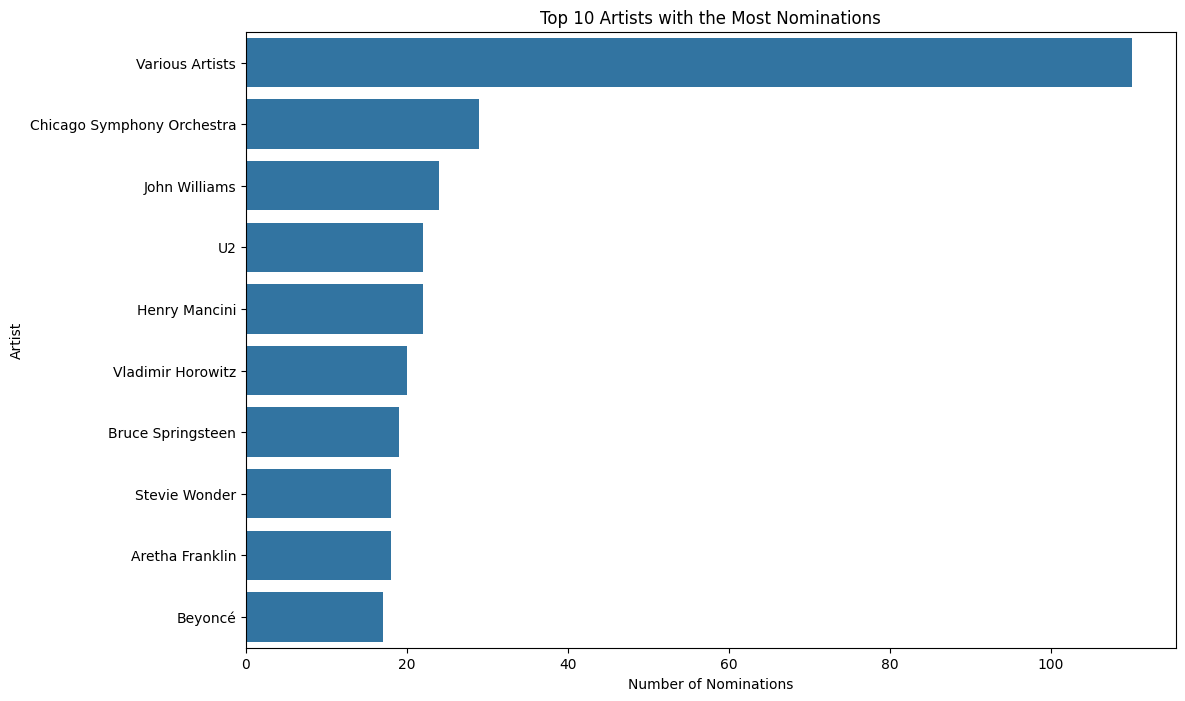

In [35]:
artist_nominations = df["artist"].value_counts().head(10)

plt.figure(figsize=(12, 8))

sns.barplot(x=artist_nominations.values,
            y=artist_nominations.index)

plt.title("Top 10 Artists with the Most Nominations")
plt.xlabel("Number of Nominations")
plt.ylabel("Artist")

plt.show()

"Various Artists" lidera con alrededor de 100 nominaciones, seguido por la Chicago Symphony Orchestra (~80) y John Williams (~70).
Hay una caída significativa después de los primeros tres, con U2 en ~50 nominaciones y el resto entre 25 y 45.
La lista incluye una mezcla de artistas individuales (Beyoncé, Stevie Wonder), bandas (U2), compositores (John Williams), y ensembles (Chicago Symphony Orchestra).

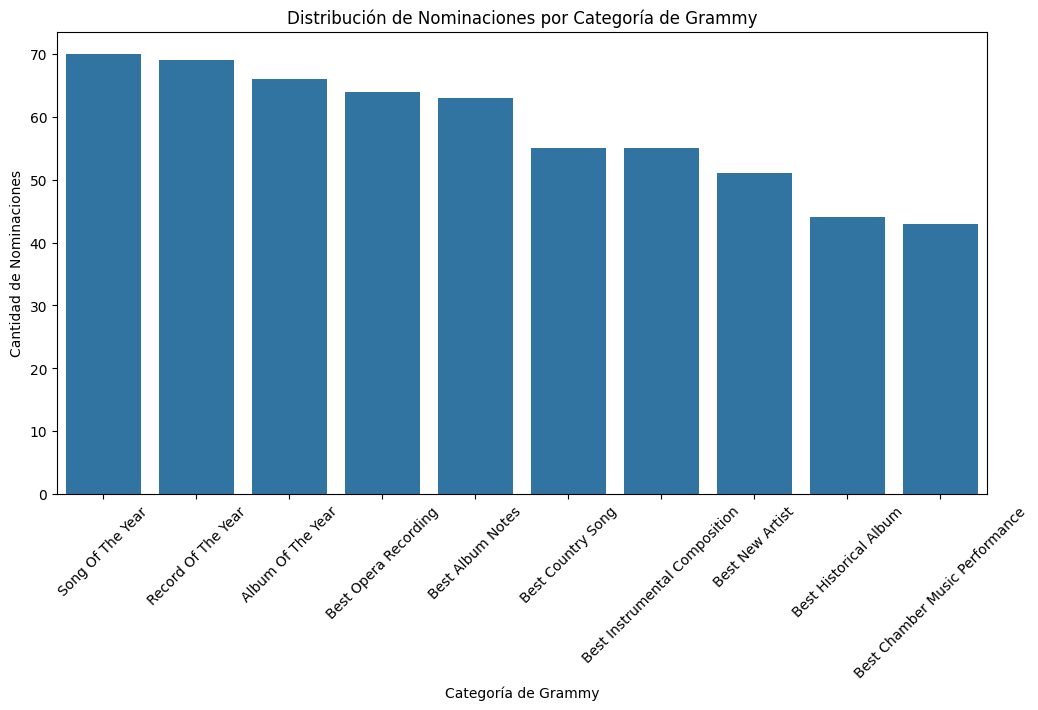

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(x="category", data=df[df["is_nominated"]], 
              order=df["category"].value_counts().index[:10])
plt.title("Distribución de Nominaciones por Categoría de Grammy")
plt.xlabel("Categoría de Grammy")
plt.ylabel("Cantidad de Nominaciones")
plt.xticks(rotation=45)
plt.show()

Categorías principales: "Song of the Year", "Record of the Year", y "Album of the Year" son las más competitivas, lo esperado dado su prestigio y alcance (abarcan todos los géneros).
Categorías de nicho: "Best Opera Recording" y "Best Chamber Music Performance" reflejan la representación de música clásica, que tiene múltiples categorías específicas.
"Best Album Notes": Su alta nominación sugiere un reconocimiento significativo a la labor de documentación histórica en la música.

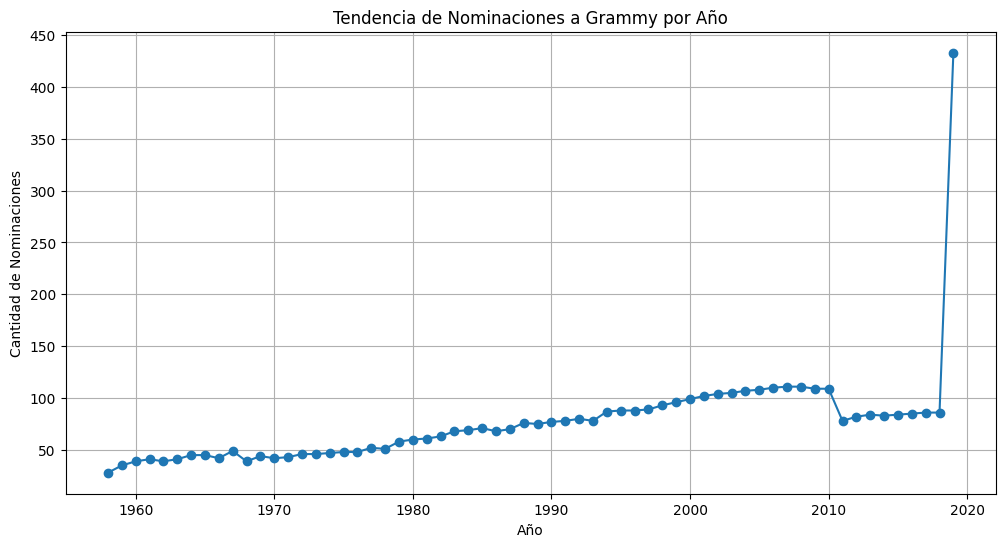

In [37]:
plt.figure(figsize=(12, 6))
yearly_nominations = df[df["is_nominated"]]["year"].value_counts().sort_index()
plt.plot(yearly_nominations.index, yearly_nominations.values, marker="o")
plt.title("Tendencia de Nominaciones a Grammy por Año")
plt.xlabel("Año")
plt.ylabel("Cantidad de Nominaciones")
plt.grid(True)
plt.show()

Las nominaciones son bajas y estables (~50) desde 1960 hasta 1980.
Hay un crecimiento gradual de 1980 a 2000, estabilizándose en ~100 nominaciones por año hasta 2010.
Una caída abrupta en 2010 (~50), seguida de un aumento exponencial en 2011-2019, con un pico de ~450 en 2019.
